# Differential Intelligence

(original by Dario Izzo - extended by Ekin Ozturk)

In this notebook we show the use of `desolver` for numerical integration following the notebook example here [differential intelligence](https://darioizzo.github.io/audi/notebooks/example10.html).

## Importing Stuff

In [1]:
import pyaudi

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import os
import numpy as np

os.environ['DES_BACKEND'] = 'numpy'
import desolver as de
import desolver.backend as D

D.set_float_fmt('gdual_double')

PyAudi backend is available.
Using numpy backend


## Controller representation and “simulator”

Take as an example the task of learning a robotic controller. In neuro evolution (or Evolutionary Robotics), the controller is typically represented by a neural network, but for the purpose of explaining this new learning concept we will use a polinomial representation for the controller. Later, changing the controller into a NN with weights as parameters will not change the essence of what is done here.

In [3]:
# Definition of the controller in terms of some weights parameters
def u(state, weights):
    x,v = state
    a,b,c,e,f,g = weights
    return a + b*x + c*v + e*x*v + f*x**2 + g*v**2

In [4]:
# Definition of the equation of motion (our physics simulator propagating the system to its next state)
def eom(state, weights):
    x,v = state
    dx = v
    dv = u(state, weights)
    return (dx, dv)

## Numerical Integration - Runge-Kutta 45 Cash-Karp Method

In Evolutionary Robotics, Euler propagators are commonly used, but we would like to use a higher order integration scheme that is adaptive in order to minimise computation, and increase the accuracy and precision of the results.

In [5]:
weights = D.array([D.gdual_double(0.05*(np.random.uniform()-0.5), _, 7) for _ in "abcefg"])
x = [D.gdual_double(2*(np.random.uniform()-0.5))]
v = [D.gdual_double(2*(np.random.uniform()-0.5))]
y0 = D.array(x + v, dtype=D.gdual_double)

In [6]:
def rhs(t, state, weights, **kwargs):
    return D.array(eom(state, weights))

We integrate the system using the Runge-Kutta-Cash-Karp scheme as the numerical integration system with a dense output computed using a piecewise C1 Hermite interpolating spline. 

This particular interpolator is used as it satisfies not only the state boundary conditions, but also the gradients and is well suited for approximating the solution continuously up to first order in time.

Note that the entire integration is done using gduals and thus the solution and the interpolating spline stored in the OdeSystem instance, `pyaudi_integration`, contains all the information about how the state reached by our robot changes when we change the control weights.

In [7]:
pyaudi_integration = de.OdeSystem(rhs, y0=y0, dense_output=False, t=(0, 10.), dt=0.1, rtol=1e-12, atol=1e-12, constants=dict(weights=weights))

pyaudi_integration.set_method("RK45")
pyaudi_integration.integrate(eta=True)

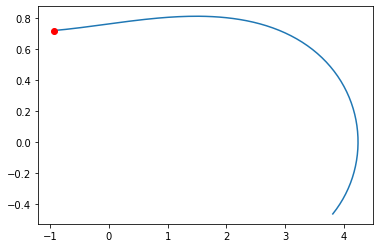

In [8]:
x,v = pyaudi_integration.y.T
plt.plot([it for it in x.astype(np.float64)],[it for it in v.astype(np.float64)])
plt.plot(x[0].constant_cf, v[0].constant_cf, 'ro')
plt.show()

In [9]:
xf, vf = x[-1], v[-1]

In [10]:
print("initial xf: {}".format(xf.constant_cf))
print("initial vf: {}".format(vf.constant_cf))

initial xf: 3.8065257635631173
initial vf: -0.4637962920728024


## Studying the effects of the weights on the behavior

We have represented all the robot behavior (x, v) as a polynomial function of the weights. So we now know what happens to the behaviour if we change the weights!! Lets see … we only consider the final state, but the same can be done for all states before.

In [11]:
dweights = dict({'da': -0.002, 'db': 0.003, 'dc': -0.02, 'de': 0.03, 'df': 0.02, 'dg': -0.01})
#Lets predict the new final position of our 'robot' if we change his controller as defined above
print("new xf: {}".format(xf.evaluate(dweights)))
print("new vf: {}".format(vf.evaluate(dweights)))

new xf: 11.843378895251684
new vf: 3.5577687770021136


## Check that we learned the correct map

We now simulate again our behavior using the new weights to see where we end up to check if the prediction made after our differential learning is correct.

In [12]:
new_weights = np.array([it + dweights['d' + it.symbol_set[0]] for it in weights])

In [13]:
pyaudi_integration2 = de.OdeSystem(rhs, y0=y0, dense_output=True, t=(0, 10.), dt=0.01, rtol=1e-12, atol=1e-12, constants=dict(weights=new_weights))

pyaudi_integration2.set_method("RK45")
pyaudi_integration2.integrate(eta=True)

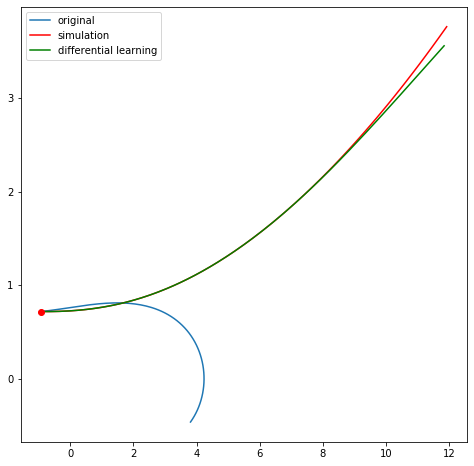

In [14]:
plt.figure(figsize=(8,8))
x2, v2 = pyaudi_integration2.y.T
plt.plot([it.constant_cf for it in x],[it.constant_cf for it in v],label='original')
plt.plot([it.constant_cf for it in x2],[it.constant_cf for it in v2],'r',label='simulation')
plt.plot([it.evaluate(dweights) for it in x],[it.evaluate(dweights) for it in v],'g',label='differential learning')
plt.plot(x[0].constant_cf, v[0].constant_cf, 'ro')
plt.legend(loc=2)
plt.show()

In [15]:
print("Differential learning xf: \t{}".format(x[-1].evaluate(dweights)))
print("Real xf: \t\t\t{}".format(x2[-1].constant_cf))
print("Mean Absolute Difference xf:\t{}".format(D.max(D.abs(D.to_float(x2[-1]) - D.to_float(x[-1].evaluate(dweights))))))
print()
print("Differential learning vf: \t{}".format(v[-1].evaluate(dweights)))
print("Real vf: \t\t\t{}".format(v2[-1].constant_cf))
print("Mean Absolute Difference vf:\t{}".format(D.max(D.abs(D.to_float(v2[-1]) - D.to_float(v[-1].evaluate(dweights))))))

Differential learning xf: 	11.843378895251684
Real xf: 			11.924939296996673
Mean Absolute Difference xf:	0.08156040174498891

Differential learning vf: 	3.5577687770021136
Real vf: 			3.7620227657073806
Mean Absolute Difference vf:	0.204253988705267
